### 8.1错误处理
通过约定错误码可以知道是否有错，以及错误的原因  
因为错误码与正常结果混在一起，因此需要大量的代码判断是否出错  


In [2]:
def foo():
    r = some_function()
    if r==(-1):
        return (-1)
    # do something
    return r

def bar():
    r = foo()
    if r==(-1):
        print('Error')
    else:
        pass

**使用try...except...finally...的错误机制**

In [3]:
try:
    print('try...')
    r = 10/0
    print('result:',r)
except ZeroDivisionError as e:
    print('except:',e)
finally:
    print('finally...')
print('END')

try...
except: division by zero
finally...
END


finally语句 如果有一定会被执行  
可以通过多个except捕获不同类型的错误   
可以通过else处理没有错误发生的情况  
错误也是类，如果第一个except捕获的是第二个except的父类，则第二个永远不会触发

In [4]:
try:
    print('try...')
    r = 10 / int('2')
    print('result:', r)
except ValueError as e:
    print('ValueError:', e)
except ZeroDivisionError as e:
    print('ZeroDivisionError:', e)
else:
    print('no error!')
finally:
    print('finally...')
print('END')

try...
result: 5.0
no error!
finally...
END


try...except捕获错误可以跨多层调用，即使在多层调用的最内层出现了错误，也可以被最外层捕获到并且处理  
**捕获错误时会出现一个调用栈信息，才能定位错误的位置**  
python内置的logging模块可以打印错误信息并继续执行

In [5]:
import logging

def foo(s):
    return 10 / int(s)

def bar(s):
    return foo(s) * 2

def main():
    try:
        bar('0')
    except Exception as e:
        logging.exception(e)

main()
print('END')

ERROR:root:division by zero
Traceback (most recent call last):
  File "<ipython-input-5-ea577b29965b>", line 11, in main
    bar('0')
  File "<ipython-input-5-ea577b29965b>", line 7, in bar
    return foo(s) * 2
  File "<ipython-input-5-ea577b29965b>", line 4, in foo
    return 10 / int(s)
ZeroDivisionError: division by zero


END


python还可以人为的抛出错误，使用raise,如无必要，尽量使用内置错误类型

In [6]:
# err_raise.py
class FooError(ValueError):
    pass

def foo(s):
    n = int(s)
    if n==0:
        raise FooError('invalid value: %s' % s)
    return 10 / n

foo('0')

FooError: invalid value: 0

In [7]:
# err_reraise.py

def foo(s):
    n = int(s)
    if n==0:
        raise ValueError('invalid value: %s' % s)
    return 10 / n

def bar():
    try:
        foo('0')
    except ValueError as e:
        print('ValueError!')
        raise

bar()

ValueError!


ValueError: invalid value: 0

在捕获错误后仅记录一下，便于后续追踪，并通过不带参数的raise将当前错误继续往上抛，也可以通过raise往上抛时改变错误类型

In [11]:
from functools import reduce

def str2num(s):
    return int(s)

def calc(exp):
    ss = exp.split('+')
    ns = map(str2num, ss)
    return reduce(lambda acc, x: acc + x, ns)

def main():
    try:
        r = calc('100 + 200 + 345')
        print('100 + 200 + 345 =', r)
        r = calc('99 + 88 + 76')
        print('99 + 88 + 76 =', r)
    except TypeError as e:
        print('Wrong input')
        
main()


100 + 200 + 345 = 645
99 + 88 + 76 = 263


### 8.2调试
+ 使用Print()把变量打印出来看
+ 使用断言，如果程序运行结果与期望不符，则抛出错误，但断言可以使用python -O来关闭断言
+ logging,与断言相比不会报错，而且可以输出到文件，还可以配置输出错误信息的级别
+ pdb,对程序进行单步调试，python -m pdb err.py，使用n前进至下一步，使用p 变量名 查看变量，q退出调试
+ pdb.set_trace()设置断点
+ IDE设置断点，如PyCharm,VS Code


### 8.3单元测试
设计测试用例，并根据用例编写单元测试，每次修改代码都需要执行单元测试，以保证修改后的代码与原行为一致

In [2]:
#编写一个类Dict模拟字典的各种操作
class Dict(dict):

    def __init__(self, **kw):
        super().__init__(**kw)

    def __getattr__(self, key):
        try:
            return self[key]
        except KeyError:
            raise AttributeError(r"'Dict' object has no attribute '%s'" % key)

    def __setattr__(self, key, value):
        self[key] = value

编写单元测试需要引入Python自带的unittest模块

编写单元测试时，我们需要编写一个测试类，从unittest.TestCase继承。  

**以test开头的方法就是测试方法，不以test开头的方法不被认为是测试方法，测试的时候不会被执行**   

对每一类测试都需要编写一个test_xxx()方法。由于unittest.TestCase提供了很多内置的条件判断，我们只需要调用这些方法就可以断言输出是否是我们所期望的。最常用的断言就是assertEqual()：  

另一种重要的断言就是期待抛出指定类型的Error，比如通过d['empty']访问不存在的key时，断言会抛出KeyError：

In [7]:
#mydict_test()
import unittest
from mydict import Dict

class TestDict(unittest.TestCase):
    def test_init(self):
        d = Dict(a=1,b='test')
        self.assertEqual(d.a,1)
        self.assertEqual(d.b,'test')
        self.assertEqual(d,dict)
        
    def test_key(self):
        d=Dict()
        d['key'] = 'value'
        self.assertEqual(d.key,'value')
        
    def test_attr(self):
        d = Dict()
        d.key ='value'
        self.assertTrue('key' in d)
        self.assertEqual(d['key'], 'value')
    
    def test_keyerror(self):
        d = Dict()
        with self.assertRaises(KeyError):
            value = d['empty']

    def test_attrerror(self):
        d = Dict()
        with self.assertRaises(AttributeError):
            value = d.empty
            
if __name__ == '__main__':
    unittest.main()

ImportError: No module named 'mydict'

**运行单元测试**

一旦编写好单元测试，我们就可以运行单元测试。最简单的运行方式是在mydict_test.py的最后加上两行代码：  
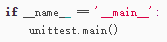  
这样就可以把mydict_test.py当做正常的python脚本运行：  

另一种方法是在命令行通过参数-m unittest直接运行单元测试：  

python -m unittest mydict_test

**setUp与tearDown**

可以在单元测试中编写两个特殊的setUp()和tearDown()方法。这两个方法会分别在每调用一个测试方法的前后分别被执行。

setUp()和tearDown()方法有什么用呢？设想你的测试需要启动一个数据库，这时，就可以在setUp()方法中连接数据库，在tearDown()方法中关闭数据库，这样，不必在每个测试方法中重复相同的代码：

In [9]:
class TestDict(unittest.TestCase):

    def setUp(self):
        print('setUp...')

    def tearDown(self):
        print('tearDown...')

### 8.4文档测试
Python的官方文档中带有的示例代码可以直接自动执行，虽然代码写在注释中   
Python中内置**文档测试doctest**可以直接提取注释中的代码并执行测试   
doctest严格按照命令行的格式判断测试结果是否正确，只有在测试异常时，使用'...'表示中间的输出

In [10]:
# mydict2.py
class Dict(dict):
    '''
    Simple dict but also support access as x.y style.

    >>> d1 = Dict()
    >>> d1['x'] = 100
    >>> d1.x
    100
    >>> d1.y = 200
    >>> d1['y']
    200
    >>> d2 = Dict(a=1, b=2, c='3')
    >>> d2.c
    '3'
    >>> d2['empty']
    Traceback (most recent call last):
        ...
    KeyError: 'empty'
    >>> d2.empty
    Traceback (most recent call last):
        ...
    AttributeError: 'Dict' object has no attribute 'empty'
    '''
    def __init__(self, **kw):
        super(Dict, self).__init__(**kw)

    def __getattr__(self, key):
        try:
            return self[key]
        except KeyError:
            raise AttributeError(r"'Dict' object has no attribute '%s'" % key)

    def __setattr__(self, key, value):
        self[key] = value

if __name__=='__main__':
    import doctest
    doctest.testmod()

In [11]:
%run mydict2.py

ERROR:root:File `'mydict2.py'` not found.


如果文件什么输出都没有，则编写的doctest都是正确的

In [22]:
def fact(n):
    '''
    Calculate 1*2*...*n

    >>> fact(1)
    1
    >>> fact(10)
    3628800
    >>> fact(-1)
    Traceback (most recent call last):
        ...
    ValueError
    '''
    if n < 1:
        raise ValueError()
    if n == 1:
        return 1
    return n * fact(n - 1)


if __name__ == '__main__':
    import doctest
    doctest.testmod()